In [ ]:
import pandas as pd
from prophet import Prophet

# Load the data
data_path = '/content/LymanDataForPred.csv'
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])

# Fill missing ' ItemSold' and sort the data
data['ItemSold'] = data.groupby('Category Size')['ItemSold'].transform(lambda x: x.fillna(x.mean()))
data_sorted = data.sort_values(by=['Category Size', 'Date'])

# Resample to monthly data and interpolate missing values
data_monthly = data_sorted.groupby('Category Size').resample('M', on='Date')['ItemSold'].median().reset_index()
data_monthly['ItemSold'] = data_monthly.groupby('Category Size')['ItemSold'].transform(lambda x: x.interpolate())

# Forecast using Prophet for each Category Size and calculate accuracy
forecasts = pd.DataFrame()

# Forecast using Prophet for each Category Size
for CategorySize, group in data_monthly.groupby('Category Size'):
    if group['ItemSold'].notnull().sum() < 2:
        print(f"Skipping {CategorySize} due to insufficient data.")
        continue  # Skip to the next iteration

    # Prepare the data for Prophet
    df_prophet = pd.DataFrame({
        'ds': group['Date'],
        'y': group['ItemSold']
    })

    # Create and fit the Prophet model
    model = Prophet(yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False)
    model.fit(df_prophet)

    # Make a future dataframe for April to September 2024
    future = pd.date_range(start='2024-06-01', end='2024-08-01', freq='M')
    future = pd.DataFrame({'ds': future})

    # Forecast
    forecast = model.predict(future)

    # Add Category Size column to forecast dataframe
    forecast['Category Size'] = CategorySize

    # Append the results
    forecasts = pd.concat([forecasts, forecast], axis=0)


# Print forecasts
print(forecasts[['Category Size', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']])


DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwj5t4dc/dcci5hag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwj5t4dc/py2q3kag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29702', 'data', 'file=/tmp/tmpzwj5t4dc/dcci5hag.json', 'init=/tmp/tmpzwj5t4dc/py2q3kag.json', 'output', 'file=/tmp/tmpzwj5t4dc/prophet_modelxlntyj0c/prophet_model-20240719104228.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:42:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwj5t4dc/ylljz2cw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzwj5t4dc/aw36akj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

         Category Size         ds       yhat  yhat_lower  yhat_upper
0    A-MN_.3125X96X288 2024-06-30  -0.059254   -8.776701   10.420098
1    A-MN_.3125X96X288 2024-07-31   6.772181   -3.580468   16.598066
0     A-MN_.375X96X288 2024-06-30  24.635424    2.815063   44.221399
1     A-MN_.375X96X288 2024-07-31  26.863231    7.100632   46.915918
0       A-MN_.5X96X288 2024-06-30  15.053726    4.361611   25.452412
..                 ...        ...        ...         ...         ...
1   AR 500F_1.5X96X288 2024-07-31  -0.144852   -0.955101    0.660144
0     AR 500F_1X96X288 2024-06-30   1.478405   -2.723241    5.484851
1     AR 500F_1X96X288 2024-07-31   5.252492    0.774356    9.579549
0     AR 500F_2X96X288 2024-06-30   2.351428    1.321786    3.438011
1     AR 500F_2X96X288 2024-07-31   0.978051   -0.044534    2.031035

[72 rows x 5 columns]


In [ ]:
!pip install ipywidgets

In [ ]:
# Print forecasts
OutForecast=(forecasts[['Category Size', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']])
OutForecast.to_csv('/content/ProphtForecastLyman.csv', index=False)
print(OutForecast)


         Category Size         ds       yhat  yhat_lower  yhat_upper
0    A-MN_.3125X96X288 2024-06-30  -0.059254   -8.776701   10.420098
1    A-MN_.3125X96X288 2024-07-31   6.772181   -3.580468   16.598066
0     A-MN_.375X96X288 2024-06-30  24.635424    2.815063   44.221399
1     A-MN_.375X96X288 2024-07-31  26.863231    7.100632   46.915918
0       A-MN_.5X96X288 2024-06-30  15.053726    4.361611   25.452412
..                 ...        ...        ...         ...         ...
1   AR 500F_1.5X96X288 2024-07-31  -0.144852   -0.955101    0.660144
0     AR 500F_1X96X288 2024-06-30   1.478405   -2.723241    5.484851
1     AR 500F_1X96X288 2024-07-31   5.252492    0.774356    9.579549
0     AR 500F_2X96X288 2024-06-30   2.351428    1.321786    3.438011
1     AR 500F_2X96X288 2024-07-31   0.978051   -0.044534    2.031035

[72 rows x 5 columns]


In [ ]:
# Create an empty list to store the forecast data
forecast_output = []

# Iterate through each group of forecasts
for CategorySize, group in forecasts.groupby('Category Size'):
    # Iterate through each row in the group
    for index, row in group.iterrows():
        # Calculate the accuracy
        accuracy = row['yhat_upper'] - row['yhat_lower']
        #Calculate Accuraacy Score
        # Calculate the accuracy score as a percentage
        accuracy_score = (accuracy / row['yhat']) * 100
        # Format accuracy score as percentage string
        accuracy_score_str = "{:.2f}%".format(accuracy_score)
        # Append the forecast data to the list
        forecast_output.append({
            'Category Size': CategorySize,
            'Date': row['ds'].strftime('%Y-%m-%d'),
            'Forecast': row['yhat'],
            'Lower': row['yhat_upper'],
            'Upper': row['yhat_lower'],
            'Confidence Interval': accuracy,
            'Accuracy Score': accuracy_score_str
        })

# Convert the list of dictionaries to a DataFrame
forecast_df = pd.DataFrame(forecast_output)

print(forecast_df)
Data=forecast_df
# Save the DataFrame to a CSV file
forecast_df.to_csv('/content/ProphetForecastLymanCI.csv', index=False)


         Category Size        Date   Forecast      Lower     Upper  \
0    A-MN_.3125X96X288  2024-06-30  -0.059254  10.420098 -8.776701   
1    A-MN_.3125X96X288  2024-07-31   6.772181  16.598066 -3.580468   
2     A-MN_.375X96X288  2024-06-30  24.635424  44.221399  2.815063   
3     A-MN_.375X96X288  2024-07-31  26.863231  46.915918  7.100632   
4       A-MN_.5X96X288  2024-06-30  15.053726  25.452412  4.361611   
..                 ...         ...        ...        ...       ...   
67  AR 500F_1.5X96X288  2024-07-31  -0.144852   0.660144 -0.955101   
68    AR 500F_1X96X288  2024-06-30   1.478405   5.484851 -2.723241   
69    AR 500F_1X96X288  2024-07-31   5.252492   9.579549  0.774356   
70    AR 500F_2X96X288  2024-06-30   2.351428   3.438011  1.321786   
71    AR 500F_2X96X288  2024-07-31   0.978051   2.031035 -0.044534   

    Confidence Interval Accuracy Score  
0             19.196799     -32397.36%  
1             20.178535        297.96%  
2             41.406336        168.0

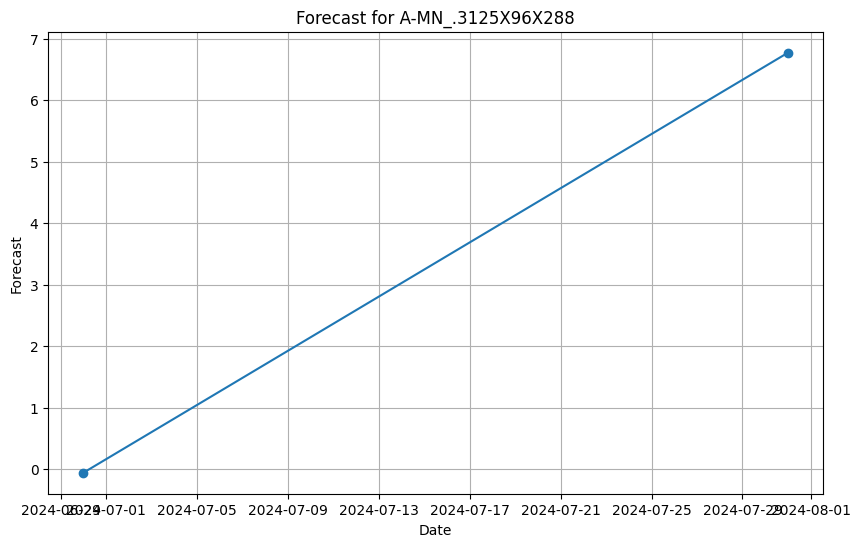

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets



# Create a DataFrame
df = pd.DataFrame(Data)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Function to plot forecast for a selected category size
def plot_forecast(category_size):
    # Filter the DataFrame for the selected category size
    filtered_df = df[df['Category Size'] == category_size]

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['Date'], filtered_df['Forecast'], marker='o', linestyle='-')
    plt.title(f'Forecast for {category_size}')
    plt.xlabel('Date')
    plt.ylabel('Forecast')
    plt.grid(True)
    plt.show()

# Example usage
plot_forecast('A-MN_.3125X96X288')


In [ ]:
# Create a dropdown widget
category_dropdown = widgets.Dropdown(
    options=df['Category Size'].unique(),
    description='Category Size:'
)

# Use interact to create the interactive plot
interact(plot_forecast, category_size=category_dropdown)

interactive(children=(Dropdown(description='Category Size:', options=('A-MN_.3125X96X288', 'A-MN_.375X96X288',…

<function __main__.plot_forecast(category_size)>